In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [2]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

## Load the data

In [4]:
pwd

'/tf/notebooks/final-project/Classification'

In [5]:
!head -2 /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [6]:
!cat /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt | wc -l

283399


In [6]:
data_path = '/tf/notebooks/final-project/data/sample/hein-daily'

In [7]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [6]:
len(all_speech_ids), len(all_speeches)

(283399, 283399)

## Create target labels

#### TODO:

- Why is this taking so much time?
- Subset on word cound here?
- Make sampling replicable: random seed + random array of proper length

In [3]:
%whos

Variable          Type        Data/Info
---------------------------------------
absolute_import   _Feature    _Feature((2, 5, 0, 'alpha<...>0, 0, 'alpha', 0), 16384)
division          _Feature    _Feature((2, 2, 0, 'alpha<...> 0, 0, 'alpha', 0), 8192)
explore_data      module      <module 'helpers.explore_<...>helpers/explore_data.py'>
gc                module      <module 'gc' (built-in)>
load_data         module      <module 'helpers.load_dat<...>on/helpers/load_data.py'>
np                module      <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
os                module      <module 'os' from '/usr/lib/python3.5/os.py'>
pd                module      <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
pickle            module      <module 'pickle' from '/u<...>lib/python3.5/pickle.py'>
preprocess_data   module      <module 'helpers.preproce<...>pers/preprocess_data.py'>
print_function    _Feature    _Feature((2, 6, 0, 'alpha<...>0, 0, 'alpha', 0), 65536)
random         

In [4]:
gc.collect()

0

In [19]:
del descr

In [2]:
!cat /tf/notebooks/final-project/data/QA/full_descr.txt | wc -l

2914465


In [ ]:
# OPEN descr FROM A SAVED FILE (if it was previously saved)
outdata_path = '/home/yulia/final-project/Classification/data'
descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

37,617 fuzzy match speeches had multiple duplicates. Delete them from the dictionary

In [3]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data('/tf/notebooks/final-project/data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1110114679
Age 54.0
date 20100528
Female 1.0
match exact
Party R
Congress 111
Chamber H
speakerid 111117480.0
NonWhite 0.0
Ethnicity W
check 1
speaker Mrs. BACHMANN
word_count 10
State MN
Full Name BACHMANN, MICHELE
Age_lt_med 1.0
char_count 49

It took 17.8 seconds to create the dictionary


In [7]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.9634876258550458

In [10]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(283399, 283399, 283399, 283399, 283399, 283399)

### Save descr dictionary

In [15]:
pwd

'/tf/notebooks/final-project/Classification'

In [16]:
outdata_path = '/tf/notebooks/final-project/Classification/data'

In [17]:
pickle.dump(descr, open(os.path.join(outdata_path, 'descr.p'), 'wb'))

In [ ]:
descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

### Data QA

In [18]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,216695
1,0,65350
2,1,1354


Target group number of speeches by party:
D: 	 656
I: 	 0
N: 	 0
NA: 	 -216695
R: 	 698

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,216695
1,0,63861
2,1,2843


Target group number of speeches by party:
D: 	 2463
I: 	 0
N: 	 41
NA: 	 -216695
R: 	 339

 Age
Overall speech counts:


,Category,Count
0,-1,216695
1,0,43425
2,1,23279


Target group number of speeches by party:
D: 	 12425
I: 	 0
N: 	 41
NA: 	 -216695
R: 	 10813


## Split into train, validate, test

In [22]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 499 ones and 499 zeroes
Training speech list size: 998
Training target list size: 998
Validation split: 166 ones and 166 zeroes
Validation speech list size: 332
Validation target list size: 332
Test split: 167 ones and 167 zeroes
Test speech list size: 334
Test target list size: 334


In [20]:
sum(train_target), sum(val_target), sum(test_target)

(499, 166, 167)

In [21]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

522

## CNN

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [38]:
reload(explore_data)
explore_data.get_num_words_per_sample(train)

199.0

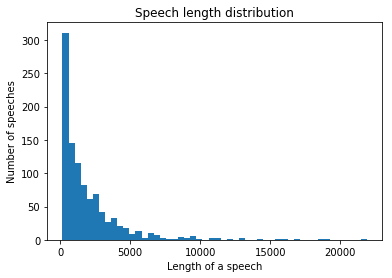

In [39]:
explore_data.plot_sample_length_distribution(train)

In [40]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_length': MAX_SEQUENCE_LENGTH
}

In [41]:
reload(preprocess_data)
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)

In [42]:
len(train), len(val), len(test)

(998, 332, 334)

In [43]:
len(train_vec), len(val_vec), len(test_vec)

(998, 332, 334)

In [44]:
train_vec[0].shape

(750,)

In [45]:
word_index['conlvince']

19033

## SepCNN Model

In [46]:
logs_base_dir = "/tf/notebooks/final-project/Classification/logs"

In [66]:
model_params = {
    'learning_rate': 1e-3,
    'epochs': 1000,
    'batch_size': 128,
    'blocks': 2,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 200,
    'kernel_size': 3,
    'pool_size': 1,
    'top_k': TOP_K
}

In [70]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_sequence_model(((train_vec, train_target), (val_vec, val_target)), word_index, logs_base_dir, **model_params)

Train on 998 samples, validate on 332 samples
Epoch 1/1000
 - 6s - loss: 0.6931 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/1000
 - 5s - loss: 0.6935 - acc: 0.4739 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/1000
 - 5s - loss: 0.6933 - acc: 0.4860 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/1000
 - 5s - loss: 0.6930 - acc: 0.4910 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/1000
 - 5s - loss: 0.6934 - acc: 0.5090 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/1000
 - 5s - loss: 0.6929 - acc: 0.5150 - val_loss: 0.6932 - val_acc: 0.5000
Validation accuracy: 0.5, loss: 0.6931503314569772


## Model evaluation

In [58]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

166

Confusion matrix, without normalization
[[166   0]
 [166   0]]


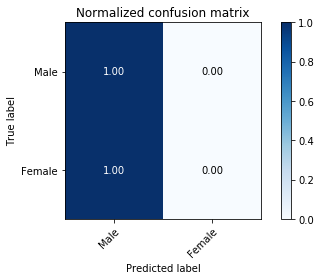

In [59]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

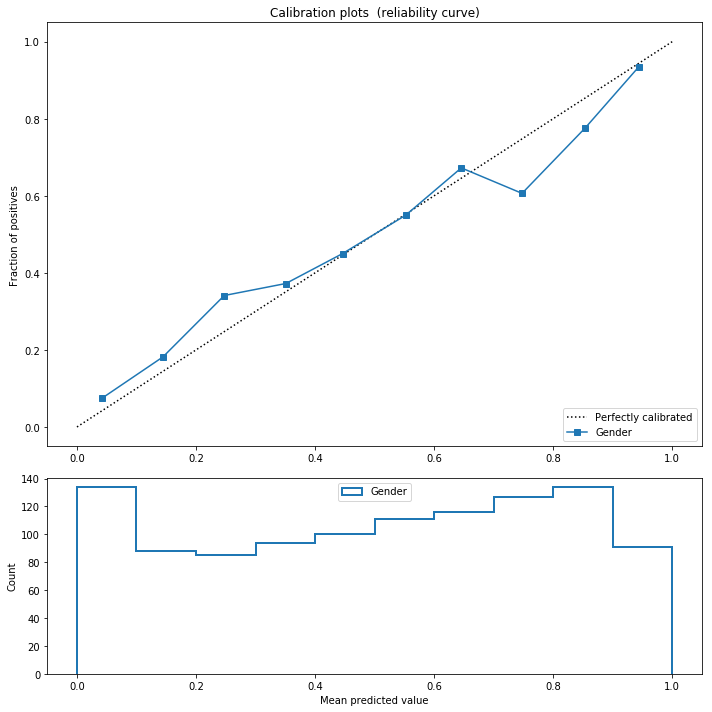

In [118]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [25]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.3303030303030303

In [40]:
# val_target_sample = np.array(val_target)[val_random==1]
val_sample = np.array(val)[val_random==1]
val_ids_sample = np.array(val_ids)[val_random==1]
val_pred_probs_sample = val_pred_probs[val_random==1]
val_sample.shape, val_ids_sample.shape, val_pred_probs_sample.shape

((109,), (109,), (109, 1))

In [48]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_pred_probs_sample, val_ids_sample, descr)

Finished building main df
Finished bin 0.4
Finished bin 0.6
Finished bin 1.0


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.64,0.83,1.04,0.79,0.74,0.72
0.6,0.88,2.06,1.00,1.05,0.95,0.95
1.0,1.33,0.61,0.97,1.13,1.22,1.23


In [65]:
len(train)

990

In [69]:
len(val)

330

In [89]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs)


Top 10 ngrams by differentiating score:
the senator from 	 11.0
mr president ask 	 7.8
we should be 	 7.6
printed in the 	 6.7
consent that the 	 6.7
unanimous consent that the 	 6.7
and it has 	 6.0
come up with 	 6.0
chairman rise in 	 5.9
mr chairman rise in 	 5.9


,0.4,0.6,1.0
and it has,0.0,4.0,0.0
chairman rise in,3.0,1.0,15.0
come up with,0.0,4.0,0.0
consent that the,6.0,0.0,0.0
mr chairman rise in,3.0,1.0,15.0
mr president ask,10.0,1.0,1.0
printed in the,9.0,1.0,1.0
the senator from,22.0,2.0,1.0
unanimous consent that the,6.0,0.0,0.0
we should be,0.0,5.0,0.0


In [41]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

would like to
the gentleman from
unanimous consent that
the federal government
of my amendment
in order to
in connection with
ask unanimous consent that
ask unanimous consent
to do so
--------------------

In 0.6 bin top 10 ngrams:

the st lawrence seaway
the st lawrence
st lawrence seaway
for health planning
the insanity defense
the gentleman from
that there is
st lawrence seaway development
percent of the
of health care
--------------------

In 1.0 bin top 10 ngrams:

would like to
armed services committee
the gentleman from
the soviet union
the armed services committee
the armed services
the united states
the office of
one of the
urge my colleagues
--------------------


In [57]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr)

15

True positive (Predicted prob: 0.94):

speakerid 97106680.0
Female 1.0
Ethnicity W
State NY
match exact
date 19820126
Age 47.0
Full Name FERRARO, GERALDINE
word_count 270
Chamber H
Congress 97
speaker Ms. FERRARO
Party D
Age_lt_med 1.0
NonWhite 0.0
char_count 1748

 Mr. Speaker. January 22. 1918. commemorates an important and emotional day in Ukrainian history. It was on this day that the people of the Ukraine achieved their freedom and independence from their powerful neighbors. This freedom and independence. however. was short lived. By 1920 the Ukrainian independent state was crushed by a more powerful Soviet Government. As Americans. we direct our attention to the plight of the Ukrainian people for several reasons. First. the Ukraine is the largest nonRussian nation both within the Soviet Union and all of Eastern Europe. Second. as Americans. most of us have not been subjected to harassment. arrest or persecution because of our personal beliefs. The United States has the right 